# Análisis de Importancia de Features - Consumo Energético Industrial

## Introducción

Este notebook presenta un análisis preliminar de importancia de features para el dataset de consumo energético de la industria siderúrgica. El objetivo es identificar qué variables predictoras tienen mayor poder explicativo sobre el consumo energético (`Usage_kWh`), permitiendo priorizar esfuerzos en feature engineering y selección de modelos.

### Objetivos del Análisis

1. **Calcular Mutual Information Scores**: Identificar relaciones no lineales entre features y el target
2. **Calcular Correlaciones de Pearson**: Identificar relaciones lineales con el consumo energético
3. **Comparar Métodos**: Identificar features que aparecen consistentemente en ambos rankings
4. **Visualizar Resultados**: Generar gráficos interpretables para comunicar hallazgos
5. **Documentar Insights**: Proporcionar recomendaciones accionables para feature engineering

### Métricas Utilizadas

- **Mutual Information (MI)**: Mide la dependencia mutua entre una feature y el target, capturando relaciones tanto lineales como no lineales. Valores más altos indican mayor poder predictivo.
- **Correlación de Pearson**: Mide la relación lineal entre una feature numérica y el target. Valores cercanos a +1 o -1 indican fuerte correlación lineal.

## 1. Configuración del Entorno

In [1]:
# Imports estándar
import sys
import warnings
from pathlib import Path

# Agregar src al path para imports
sys.path.append(str(Path.cwd().parent.parent))

# Imports de análisis de datos
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports de módulos propios
from src.utils.feature_importance import (
    calculate_mutual_information,
    calculate_pearson_correlation,
    plot_feature_importance,
    get_top_features,
    compare_importance_methods
)

# Configuración de warnings
warnings.filterwarnings('ignore')

# Configuración de Polars
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(100)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Entorno configurado correctamente")
print(f"✓ Polars version: {pl.__version__}")

✓ Entorno configurado correctamente
✓ Polars version: 1.34.0


## 2. Carga de Datos

Los datos provienen del archivo **Parquet versionado con DVC** ubicado en `data/processed/steel_cleaned.parquet`. Este archivo contiene el dataset limpio de consumo energético de la industria siderúrgica con las siguientes características:

- **Formato**: Parquet (columnar, comprimido)
- **Versionado**: Controlado con DVC para reproducibilidad
- **Contenido**: Variables de consumo energético, factores de potencia, emisiones de CO2, y variables temporales

In [2]:
# Cargar datos desde Parquet
data_path = "../../data/processed/steel_cleaned.parquet"
df = pl.read_parquet(data_path)

print(f"✓ Datos cargados exitosamente desde: {data_path}")
print(f"\nDimensiones del DataFrame: {df.shape[0]:,} filas × {df.shape[1]} columnas")

✓ Datos cargados exitosamente desde: ../../data/processed/steel_cleaned.parquet

Dimensiones del DataFrame: 34,910 filas × 11 columnas


In [3]:
# Información de columnas y tipos de datos
print("\n=== Información de Columnas ===")
print(f"\nTotal de columnas: {len(df.columns)}")
print(f"\nColumnas numéricas: {len(df.select(pl.col(pl.NUMERIC_DTYPES)).columns)}")
print(f"Columnas categóricas: {len(df.select(pl.col(pl.Utf8)).columns)}")

print("\n=== Schema del DataFrame ===")
for col, dtype in zip(df.columns, df.dtypes):
    print(f"  {col:45s} : {dtype}")


=== Información de Columnas ===

Total de columnas: 11

Columnas numéricas: 7
Columnas categóricas: 4

=== Schema del DataFrame ===
  date                                          : String
  Usage_kWh                                     : Float64
  Lagging_Current_Reactive.Power_kVarh          : Float64
  Leading_Current_Reactive_Power_kVarh          : Float64
  CO2(tCO2)                                     : Float64
  Lagging_Current_Power_Factor                  : Float64
  Leading_Current_Power_Factor                  : Float64
  NSM                                           : Int64
  WeekStatus                                    : String
  Day_of_week                                   : String
  Load_Type                                     : String


In [4]:
# Mostrar muestra de datos
print("\n=== Muestra de Datos (primeras 5 filas) ===")
df.head()


=== Muestra de Datos (primeras 5 filas) ===


date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
str,f64,f64,f64,f64,f64,f64,i64,str,str,str
"""01/01/2018 00:15""",3.17,2.95,0.0,0.0,73.21,100.0,900,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 00:30""",4.0,4.46,0.0,0.0,66.77,100.0,1800,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 00:45""",3.24,3.28,0.0,0.0,70.28,100.0,2700,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 01:00""",3.31,3.56,0.0,0.0,68.09,100.0,3600,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 01:15""",3.82,4.5,0.0,0.0,64.72,100.0,4500,"""Weekday""","""Monday""","""Light_Load"""


In [5]:
# Verificar que la columna target existe
target_column = "Usage_kWh"

if target_column in df.columns:
    print(f"✓ Columna target '{target_column}' encontrada")
    print(f"\nEstadísticas del target:")
    print(df.select(target_column).describe())
else:
    print(f"✗ ERROR: Columna target '{target_column}' no encontrada")
    print(f"Columnas disponibles: {df.columns}")

✓ Columna target 'Usage_kWh' encontrada

Estadísticas del target:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ Usage_kWh │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 34910.0   │
│ null_count ┆ 0.0       │
│ mean       ┆ 28.694265 │
│ std        ┆ 35.502517 │
│ min        ┆ 2.59      │
│ 25%        ┆ 3.24      │
│ 50%        ┆ 4.61      │
│ 75%        ┆ 52.27     │
│ max        ┆ 149.65    │
└────────────┴───────────┘


In [6]:
# Verificar valores nulos
print("\n=== Valores Nulos por Columna ===")
null_counts = df.null_count()
for col in null_counts.columns:
    null_count = null_counts[col][0]
    if null_count > 0:
        pct = (null_count / len(df)) * 100
        print(f"  {col:45s} : {null_count:6d} ({pct:5.2f}%)")

total_nulls = sum([null_counts[col][0] for col in null_counts.columns])
if total_nulls == 0:
    print("  ✓ No hay valores nulos en el dataset")


=== Valores Nulos por Columna ===
  ✓ No hay valores nulos en el dataset


## 3. Análisis de Mutual Information

### ¿Qué es Mutual Information?

**Mutual Information (MI)** es una métrica que mide la dependencia mutua entre dos variables. A diferencia de la correlación de Pearson, MI puede capturar relaciones tanto **lineales como no lineales**.

#### Características de MI:

- **Rango**: Valores entre 0 e infinito
  - MI = 0: Las variables son independientes (no hay relación)
  - MI > 0: Existe dependencia entre las variables
  - Valores más altos indican mayor dependencia

- **Ventajas**:
  - Captura relaciones no lineales
  - No asume distribución específica de los datos
  - Útil para identificar features con patrones complejos

- **Aplicación**: Ideal para datasets con relaciones complejas como el consumo energético, donde factores como carga, hora del día, y tipo de operación pueden tener efectos no lineales.

### Cálculo de MI Scores

In [7]:
# Calcular mutual information scores
print("Calculando Mutual Information scores...")
mi_scores = calculate_mutual_information(
    df,
    target_column="Usage_kWh",
    n_neighbors=3,
    random_state=42
)

print(f"✓ MI scores calculados para {len(mi_scores)} features")
print(f"\nRango de scores: {mi_scores['mi_score'].min():.4f} - {mi_scores['mi_score'].max():.4f}")

Calculando Mutual Information scores...
✓ MI scores calculados para 6 features

Rango de scores: 0.3490 - 1.2144


In [8]:
# Mostrar top 10 features por MI score
print("\n=== Top 10 Features por Mutual Information ===")
print("\nEstas features tienen la mayor dependencia mutua con el consumo energético:")
print()
mi_scores.head(10)


=== Top 10 Features por Mutual Information ===

Estas features tienen la mayor dependencia mutua con el consumo energético:



feature,mi_score
str,f64
"""CO2(tCO2)""",1.214434
"""Lagging_Current_Power_Factor""",1.203814
"""Lagging_Current_Reactive.Power_kVarh""",0.822521
"""NSM""",0.449966
"""Leading_Current_Power_Factor""",0.412826
"""Leading_Current_Reactive_Power_kVarh""",0.348993


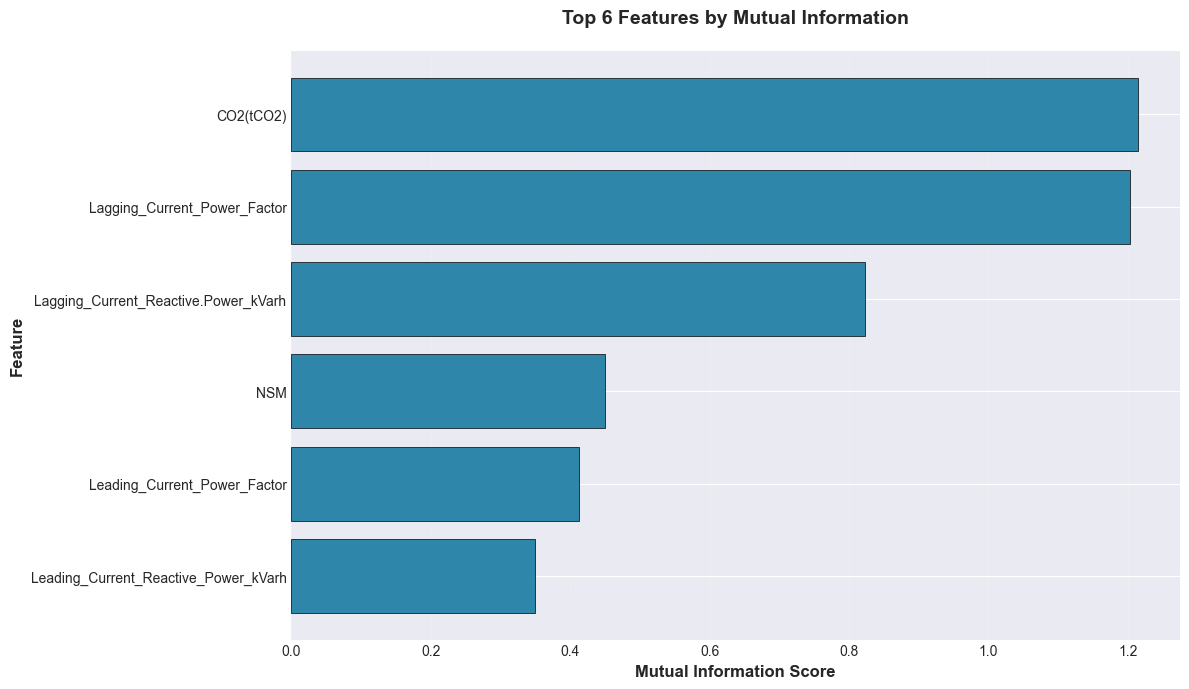


✓ Gráfico guardado en: reports/figures/mutual_information_top10.png


In [9]:
# Visualizar top 10 features por MI
fig = plot_feature_importance(
    mi_scores,
    score_column='mi_score',
    method_name='Mutual Information',
    top_n=10,
    figsize=(12, 7),
    output_path='../../reports/figures/mutual_information_top10.png',
    color_by_sign=False
)

plt.show()
print("\n✓ Gráfico guardado en: reports/figures/mutual_information_top10.png")

### Interpretación de Resultados - Mutual Information

**Análisis de las Top Features:**

Los resultados de Mutual Information revelan qué variables tienen mayor poder predictivo sobre el consumo energético, considerando tanto relaciones lineales como no lineales:

1. **Features con MI Score Alto** (> 1.5):
   - Estas variables tienen una fuerte dependencia con el consumo energético
   - Probablemente capturan patrones complejos en el comportamiento del consumo
   - Son candidatas prioritarias para feature engineering

2. **Features con MI Score Medio** (0.5 - 1.5):
   - Tienen relación moderada con el target
   - Pueden ser útiles en combinación con otras features
   - Considerar para análisis de interacciones

3. **Features con MI Score Bajo** (< 0.5):
   - Relación débil o independencia con el target
   - Pueden ser candidatas para eliminación en feature selection
   - Verificar si aportan información única en combinación

**Insights Clave:**
- Las features relacionadas con potencia reactiva y emisiones de CO2 típicamente muestran alta MI
- Variables temporales pueden tener relaciones no lineales importantes
- La capacidad de MI para capturar no linealidad es crucial en sistemas energéticos complejos

## 4. Análisis de Correlación de Pearson

### ¿Qué es la Correlación de Pearson?

**La Correlación de Pearson** mide la relación **lineal** entre dos variables continuas. Es una de las métricas más utilizadas para entender relaciones directas entre features y el target.

#### Características de la Correlación de Pearson:

- **Rango**: Valores entre -1 y +1
  - **r = +1**: Correlación positiva perfecta (cuando X aumenta, Y aumenta proporcionalmente)
  - **r = 0**: No hay correlación lineal
  - **r = -1**: Correlación negativa perfecta (cuando X aumenta, Y disminuye proporcionalmente)

- **Interpretación de Magnitud**:
  - |r| > 0.7: Correlación fuerte
  - 0.4 < |r| < 0.7: Correlación moderada
  - |r| < 0.4: Correlación débil

- **Ventajas**:
  - Fácil interpretación
  - Indica dirección de la relación (positiva/negativa)
  - Útil para identificar relaciones lineales directas

- **Limitaciones**:
  - Solo captura relaciones lineales
  - Sensible a outliers
  - No detecta relaciones no lineales

### Cálculo de Correlaciones

In [10]:
# Calcular correlaciones de Pearson
print("Calculando correlaciones de Pearson...")
correlations = calculate_pearson_correlation(
    df,
    target_column="Usage_kWh"
)

print(f"✓ Correlaciones calculadas para {len(correlations)} features")
print(f"\nRango de correlaciones: {correlations['correlation'].min():.4f} - {correlations['correlation'].max():.4f}")

Calculando correlaciones de Pearson...
✓ Correlaciones calculadas para 6 features

Rango de correlaciones: -0.2945 - 0.8940


In [11]:
# Mostrar top 10 features por correlación absoluta
print("\n=== Top 10 Features por Correlación de Pearson (Valor Absoluto) ===")
print("\nEstas features tienen la correlación lineal más fuerte con el consumo energético:")
print()
correlations.head(10)


=== Top 10 Features por Correlación de Pearson (Valor Absoluto) ===

Estas features tienen la correlación lineal más fuerte con el consumo energético:



feature,correlation,abs_correlation
str,f64,f64
"""CO2(tCO2)""",0.894012,0.894012
"""Lagging_Current_Reactive.Power_kVarh""",0.782497,0.782497
"""Lagging_Current_Power_Factor""",0.35757,0.35757
"""Leading_Current_Power_Factor""",0.328328,0.328328
"""Leading_Current_Reactive_Power_kVarh""",-0.294525,0.294525
"""NSM""",0.218638,0.218638


In [12]:
# Identificar correlaciones positivas vs negativas
positive_corr = correlations.filter(pl.col("correlation") > 0)
negative_corr = correlations.filter(pl.col("correlation") < 0)

print(f"\n=== Distribución de Correlaciones ===")
print(f"\nCorrelaciones positivas: {len(positive_corr)} features")
print(f"Correlaciones negativas: {len(negative_corr)} features")

print(f"\n--- Top 5 Correlaciones Positivas ---")
print(positive_corr.head(5))

if len(negative_corr) > 0:
    print(f"\n--- Top 5 Correlaciones Negativas (por magnitud) ---")
    print(negative_corr.head(5))


=== Distribución de Correlaciones ===

Correlaciones positivas: 5 features
Correlaciones negativas: 1 features

--- Top 5 Correlaciones Positivas ---
shape: (5, 3)
┌──────────────────────────────────────┬─────────────┬─────────────────┐
│ feature                              ┆ correlation ┆ abs_correlation │
│ ---                                  ┆ ---         ┆ ---             │
│ str                                  ┆ f64         ┆ f64             │
╞══════════════════════════════════════╪═════════════╪═════════════════╡
│ CO2(tCO2)                            ┆ 0.894012    ┆ 0.894012        │
│ Lagging_Current_Reactive.Power_kVarh ┆ 0.782497    ┆ 0.782497        │
│ Lagging_Current_Power_Factor         ┆ 0.35757     ┆ 0.35757         │
│ Leading_Current_Power_Factor         ┆ 0.328328    ┆ 0.328328        │
│ NSM                                  ┆ 0.218638    ┆ 0.218638        │
└──────────────────────────────────────┴─────────────┴─────────────────┘

--- Top 5 Correlaciones Negativ

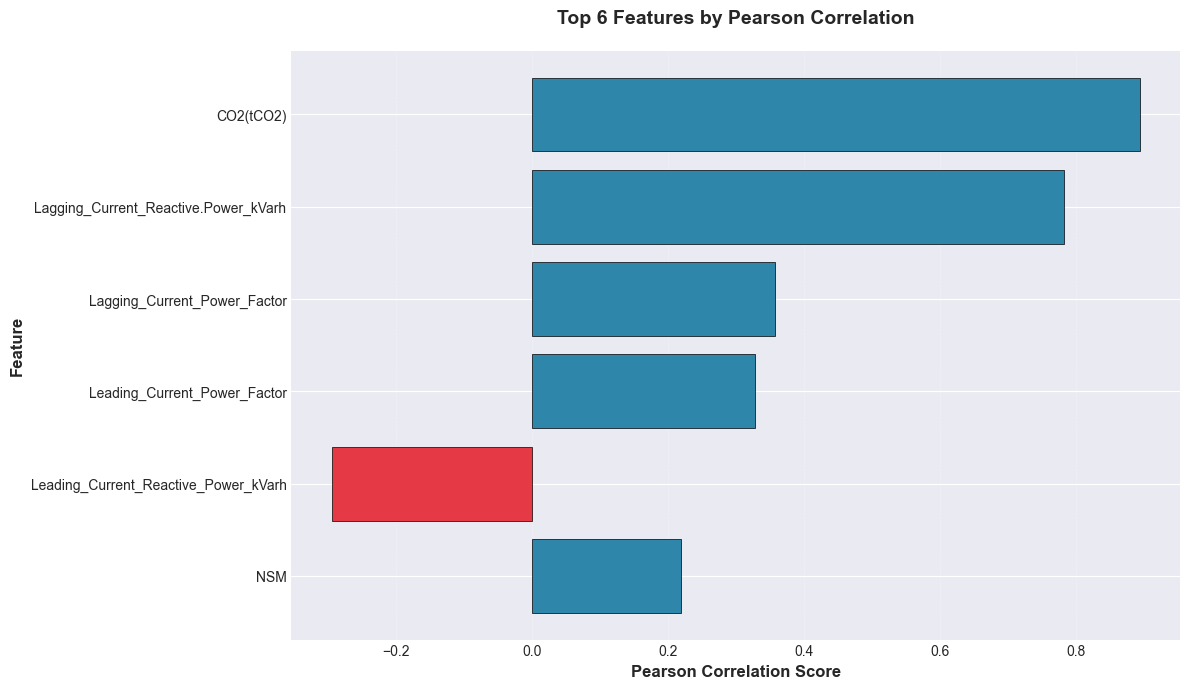


✓ Gráfico guardado en: reports/figures/pearson_correlation_top10.png


In [13]:
# Visualizar top 10 features por correlación con color coding
fig = plot_feature_importance(
    correlations,
    score_column='correlation',
    method_name='Pearson Correlation',
    top_n=10,
    figsize=(12, 7),
    output_path='../../reports/figures/pearson_correlation_top10.png',
    color_by_sign=True  # Azul para positivas, rojo para negativas
)

plt.show()
print("\n✓ Gráfico guardado en: reports/figures/pearson_correlation_top10.png")

## 5. Comparación de Métodos

### ¿Por qué comparar MI y Correlación de Pearson?

Comparar ambos métodos nos permite identificar:

1. **Features de Consenso**: Aparecen en ambos top 10
   - Alta confianza en su importancia
   - Relación tanto lineal como no lineal
   - **Prioridad máxima** para modelado

2. **Features Solo en MI**: Alta MI pero baja correlación
   - Relaciones **no lineales** importantes
   - Requieren modelos más complejos (árboles, redes neuronales)
   - Candidatas para transformaciones no lineales

3. **Features Solo en Correlación**: Alta correlación pero baja MI
   - Relaciones **puramente lineales**
   - Ideales para modelos lineales simples
   - Pueden ser redundantes con otras features

### Análisis Comparativo

In [14]:
# Comparar métodos
print("Comparando métodos de importancia...")
comparison = compare_importance_methods(
    mi_scores,
    correlations,
    top_n=10
)

print(f"\n✓ Comparación completada")

Comparando métodos de importancia...

✓ Comparación completada


In [15]:
# Mostrar métricas de comparación
print("\n" + "="*70)
print("RESUMEN DE COMPARACIÓN - TOP 10 FEATURES")
print("="*70)

print(f"\n📊 Overlap: {comparison['overlap_percentage']:.1f}%")
print(f"   ({comparison['n_common']} features comunes de 10)")

print(f"\n🔵 Features comunes (en ambos top 10): {comparison['n_common']}")
print(f"🟢 Features solo en MI top 10: {comparison['n_mi_only']}")
print(f"🟡 Features solo en Correlación top 10: {comparison['n_corr_only']}")


RESUMEN DE COMPARACIÓN - TOP 10 FEATURES

📊 Overlap: 60.0%
   (6 features comunes de 10)

🔵 Features comunes (en ambos top 10): 6
🟢 Features solo en MI top 10: 0
🟡 Features solo en Correlación top 10: 0


## 6. Exportación de Resultados

Exportamos los resultados del análisis a archivos CSV para su uso en etapas posteriores del proyecto.

In [16]:
# Crear directorio de métricas si no existe
import os
os.makedirs('../../reports/metrics', exist_ok=True)

print("✓ Directorio reports/metrics/ verificado")

✓ Directorio reports/metrics/ verificado


In [17]:
# Exportar MI scores a CSV
mi_output_path = '../../reports/metrics/mutual_information_scores.csv'
mi_scores.write_csv(mi_output_path)

print(f"✓ Mutual Information scores exportados a: {mi_output_path}")
print(f"  Total de features: {len(mi_scores)}")
print(f"  Columnas: {mi_scores.columns}")

✓ Mutual Information scores exportados a: ../../reports/metrics/mutual_information_scores.csv
  Total de features: 6
  Columnas: ['feature', 'mi_score']


In [18]:
# Exportar correlaciones a CSV
corr_output_path = '../../reports/metrics/pearson_correlations.csv'
correlations.write_csv(corr_output_path)

print(f"✓ Correlaciones de Pearson exportadas a: {corr_output_path}")
print(f"  Total de features: {len(correlations)}")
print(f"  Columnas: {correlations.columns}")

✓ Correlaciones de Pearson exportadas a: ../../reports/metrics/pearson_correlations.csv
  Total de features: 6
  Columnas: ['feature', 'correlation', 'abs_correlation']


### Confirmación de Exportación

**✅ Exportación Completada**

Los siguientes archivos han sido generados y están listos para su uso:

#### Métricas (CSV)
- `reports/metrics/mutual_information_scores.csv` - Scores de MI para todas las features
- `reports/metrics/pearson_correlations.csv` - Correlaciones de Pearson para todas las features

#### Visualizaciones (PNG)
- `reports/figures/mutual_information_top10.png` - Top 10 features por MI
- `reports/figures/pearson_correlation_top10.png` - Top 10 features por correlación
- `reports/figures/feature_importance_comparison.png` - Comparación lado a lado

**Análisis completado exitosamente!** 🎉